# Previsão como Modelos Autoregressivos Univariate

### - ARMA
### - ARIMA
### - SARIMA
### - SARIMAX

In [12]:
import pandas as pd
from pandas import Grouper, DataFrame

from typing import Tuple, List, Callable, Dict

import numpy as np
import os
from datetime import datetime
import random

from matplotlib import pyplot as plt
import seaborn as sns

import inspect
import warnings

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

from statsmodels.tsa.arima.model import ARIMA
import statsmodels.api as sm

## Constantes

In [3]:
DIR_DATASET: str = os.path.join('datasets', 'dados-gerados')

DATASET_OEC_MPME = os.path.join(DIR_DATASET,  'oec_mpme.csv')

DAT_CORRENTE = datetime.today().strftime("%Y-%m-%d")

TEST_SPLIT_SIZE = 10

MEAN_SQUARED_METRIC = "mean_squeared"
MEAN_ABSOLUTE_METRIC = "mean_absolute"
R2_METRIC = "r2"

## Funções

In [4]:
#Separa os dados em treino, teste (resultdado) para modelos autoregressivos. Não existe o conceito de janela que será utilizado 
# nos modelos de suavização e Redes Neurais
def split_train_test_window_dataset(full_dataset: np.ndarray, test_percentual_size: int) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    dataset_size: int = full_dataset.shape[0]
    cut_pos: int = round(dataset_size - (dataset_size * (test_percentual_size /100)))
    test_dataset_size: int = dataset_size - cut_pos
    
    X_test: np.ndarray = full_dataset[0 : cut_pos]
    y_test: np.ndarray = full_dataset[cut_pos:]
    
    #train_dataset_list = [full_dataset[0 : ind] for ind in range (cut_pos)]
    #X_train = np.array(train_dataset_list)
    
    test_dataset_list = [full_dataset[0:cut_pos + ind] for ind in range (test_dataset_size)]
    y_train = np.array(test_dataset_list)
    
    return X_test, y_train, y_test

In [5]:
# returns best score e a melhor ordem
get grid_search_arima(y_train: np.ndarray, y_true: np.ndarray, 
                      min_p: int=1, max_p: int=6, 
                      min_i: int=0, max_i: int=3, 
                      min_q: int=1, max_q: int = 3) -> Tuple[float, Tuple[int,int,int]]:
    

SyntaxError: invalid syntax (Temp/ipykernel_4372/1741656846.py, line 2)

## Carrega Datasets

In [6]:
df_oec_mpme = pd.read_csv(DATASET_OEC_MPME, sep=';', decimal=',', parse_dates=True)
df_oec_mpme.index = pd.DatetimeIndex(df_oec_mpme.data_base)
df_oec_mpme["ano_mes"] = pd.DatetimeIndex(df_oec_mpme.data_base).strftime('%Y-%m')
df_oec_mpme_desembolso = df_oec_mpme[['desembolso','ano','mes', 'ano_mes']]

desembolso = df_oec_mpme_desembolso[["desembolso"]].to_numpy().squeeze()
desembolso_time = df_oec_mpme_desembolso[["ano_mes"]].to_numpy().squeeze()

---
## ARIMA

In [5]:
X_test, y_train, y_true = split_train_test_window_dataset(desembolso, TEST_SPLIT_SIZE)

C:\Users\gdutr\AppData\Local\Temp/ipykernel_10872/1425785119.py:15: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  y_train = np.array(test_dataset_list)


In [ ]:
# Melhor ordem (0,2,11)
%%time
best_score = -1000000
best_order: Tuple[int,int,int] = (0,0,0)
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    for p_range in range(6):  # order for autoregressive
        for q_range in range(15): # order for moving average
            for i_range in range(3): # order for difference
                prediction_list = []
                for step in range(len(y_train)):
                    try:
                        mod = ARIMA(y_train[step], order=(p_range,i_range,q_range))
                        res = mod.fit()
                        prediction_list.append(res.forecast(steps=1))
                    except:
                        print(f'error order({p_range},{i_range},{q_range}')
                        prediction_list.append(-99999999)
                
                prediction: np.ndarray = np.array(prediction_list)
                score = r2_score(y_true, prediction)
                if score > best_score:
                    best_score = score
                    best_order = (p_range,i_range,q_range)
                    best_prediction = prediction
                    print(f'Best {best_score} com order({best_order})', end = "\r")
                else:
                    print(f'Não melhorou {score} com order({p_range},{i_range},{q_range}) - Best {best_score} com order({best_order})', end = "\r")

error order(0,1,573643492178354 com order(0,0,5) - Best 0.0206734885211719 com order((0, 1, 1)))))
error order(0,0,7366537831469381 com order(0,2,6) - Best 0.0206734885211719 com order((0, 1, 1))))
error order(0,1,791316123.04669 com order(0,0,7) - Best 0.0206734885211719 com order((0, 1, 1))
error order(0,2,791530336.7366 com order(0,1,7) - Best 0.0206734885211719 com order((0, 1, 1))


In [10]:
print(f'Melhor score {best_score} com ordem {best_order}')

Melhor score 0.2699050927764277 com ordem (0, 2, 11)


In [6]:
best_order = (0,2,11)
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    prediction_list = []
    for step in range(len(y_train)):
        mod = ARIMA(y_train[step], order=best_order)
        res = mod.fit()
        prediction_list.append(res.forecast(steps=1))
    arima_prediction = np.array(prediction_list)  


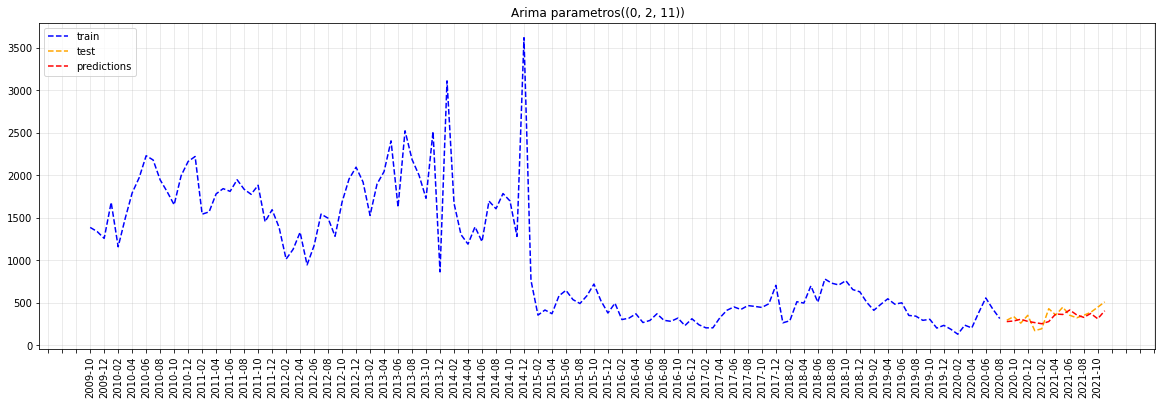

In [7]:
plt.figure(figsize=(20,6))
plt.xticks(rotation='vertical')
plt.gca().xaxis.set_major_locator(plt.MultipleLocator(2))
plt.plot(desembolso_time[:len(X_test)], X_test, 'b--', label="train")
plt.plot(desembolso_time[-len(y_true):], y_true, color='orange', linestyle="--", label="test")
plt.plot(desembolso_time[-len(arima_prediction):], arima_prediction, 'r--', label="predictions")
plt.legend(loc='upper left')
plt.title(f"Arima parametros({best_order})")
plt.grid(alpha=0.3);

In [8]:
arima_mse = mean_squared_error(y_true, arima_prediction, squared=True)
arima_mae = mean_absolute_error(y_true, arima_prediction)
arima_r2 = r2_score(y_true, arima_prediction)
print(f'Mean Squared Error: {arima_mse} ')
print(f'Mean Absolute Error: {arima_mae}')
print(f'R2 Score: {arima_r2}')

Mean Squared Error: 5857.794370726033 
Mean Absolute Error: 64.05459963019605
R2 Score: 0.2699050927764277



---
## SARIMA


In [7]:
X_test, y_train, y_true = split_train_test_window_dataset(desembolso, TEST_SPLIT_SIZE)

C:\Users\gdutr\AppData\Local\Temp/ipykernel_4372/1425785119.py:15: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  y_train = np.array(test_dataset_list)


In [ ]:
# Melhor ordem (0,2,11)
%time
best_score = -1000000
best_order: Tuple[int,int,int] = (0,0,0)
best_seasonal_order: Tuple[int,int,int] = (0,0,0)
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    for p in range(2):  # order for autoregressive
        for q in range(12): # order for moving average
            for i in range(2): # order for difference
                for P in range(2): #order for seasonal AR
                    for Q in range(2): #order for seasonal moving Average
                        for D in range(2): #order for seasonal Difference
                            prediction_list = []
                            for step in range(len(y_train)):
                                
                                mod = sm.tsa.statespace.SARIMAX(y_train[step], order=(p,i,q), seasonal_order=(P,D,Q,12))
                                res = mod.fit(disp=False)
                                prediction_list.append(res.forecast(steps=1))
                                #except:
                                 #   print(f'error order({p},{i},{q}) | Sorder({P},{D},{Q})')
                                 #   prediction_list.append(-99999999)

                            prediction: np.ndarray = np.array(prediction_list)
                            score = r2_score(y_true, prediction)
                            if score > best_score:
                                best_score = score
                                best_order = (p,i,q)
                                best_seasonal_order = (P,D,Q)
                                best_prediction = prediction
                                print(f'Best {best_score} com order({best_order}) e seasonal order({best_seasonal_order})', end = "\r")
                            else:
                                print(f'Não melhorou {score} com o=({p},{i},{q}) so=({P},{D},{Q}) - Best {best_score} com o=({p},{i},{q}) so=({P},{D},{Q})', end = "\r")

Wall time: 0 ns


In [ ]:
%%time